PyTorch está utilizando la GPU
Forma inicial del DataFrame: (1446, 200)
Primeras 5 filas del DataFrame original:
     0       0.1  0.052999  0.247331  0.635994  1.271988  2.137646   3.23297  \
0  0.0  0.000000  0.003418  0.009683  0.013101  0.017088  0.018227  0.019366   
1  0.0  0.000000  0.088332  0.353330  0.847992  1.536986  2.437977  3.533300   
2  0.0  0.010822  0.012531  0.010822  0.029619  0.039303  0.043859  0.045568   
3  0.0  0.000000  0.052999  0.264998  0.688994  1.360321  2.296645  3.427301   
4  0.0 -0.007405 -0.003418 -0.001709 -0.001139  0.004557  0.004557 -0.008544   

   4.628623  6.289274  ...  Unnamed: 190  Unnamed: 191  Unnamed: 192  \
0  0.022784  0.019366  ...           NaN           NaN           NaN   
1  4.840621  6.359940  ...           NaN           NaN           NaN   
2  0.052403  0.045568  ...           NaN           NaN           NaN   
3  4.769955  6.359940  ...           NaN           NaN           NaN   
4 -0.021075 -0.017088  ...           NaN      

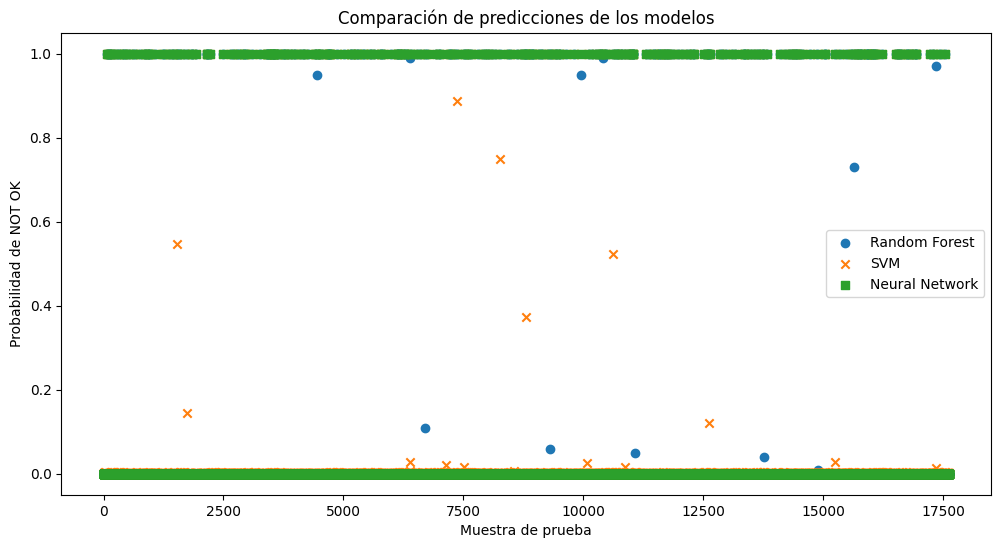

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
import os

# Verificar si PyTorch está usando la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("PyTorch está utilizando la GPU")
else:
    print("PyTorch no está utilizando la GPU")

# Crear carpeta para guardar los modelos si no existe
os.makedirs('modelos', exist_ok=True)

# Cargar y preparar los datos
file_path = r'C:\Users\luisg\OneDrive\Documentos\Proyecto_Fiverr\src\data\viejos\14_2.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')
print("Forma inicial del DataFrame:", df.shape)
print("Primeras 5 filas del DataFrame original:")
print(df.head())

df = df.dropna(axis=1, how='all').dropna(how='all')
print("\nForma del DataFrame después de eliminar filas y columnas vacías:", df.shape)

df_transposed = df.transpose().reset_index(drop=True)
df_transposed.columns = [f'Col_{i}' for i in range(len(df_transposed.columns))]

print("\nPrimeras 5 filas del DataFrame transpuesto:")
print(df_transposed.head())

# Convertir a numérico y limpiar
for col in df_transposed.columns:
    df_transposed[col] = pd.to_numeric(df_transposed[col], errors='coerce')
df_transposed = df_transposed.dropna(how='all')
df_transposed = df_transposed.iloc[:, :-3]

print("\nForma del DataFrame después de la limpieza:", df_transposed.shape)
print("Valores únicos en la primera fila:", df_transposed.iloc[0].unique())

# Separar los datos en OK y NOT OK
ok_mask = df_transposed.iloc[0] == 0
not_ok_mask = df_transposed.iloc[0] == 2

df_ok = df_transposed.loc[:, ok_mask].reset_index(drop=True)
df_not_ok = df_transposed.loc[:, not_ok_mask].reset_index(drop=True)

print("\nNúmero de columnas OK:", df_ok.shape[1])
print("Número de columnas NOT OK:", df_not_ok.shape[1])

def prepare_data(df, window_size=10):
    X = []
    y = []
    for i in range(1, df.shape[1], 2):
        if i + 1 >= df.shape[1]:
            break  # Evita acceder a una columna fuera del rango
        angulo = df.iloc[1:, i].dropna().values
        par = df.iloc[1:, i+1].dropna().values
        min_len = min(len(angulo), len(par))
        if min_len > window_size:
            for j in range(min_len - window_size):
                X.append(np.column_stack((angulo[j:j+window_size], par[j:j+window_size])).flatten())
                y.append(df.iloc[0, i])
    return np.array(X), np.array(y)

# Preparar los datos
X_ok, y_ok = prepare_data(df_ok)
X_not_ok, y_not_ok = prepare_data(df_not_ok)

# Verificar si tenemos datos suficientes
if len(X_ok) == 0 or len(X_not_ok) == 0:
    print("No hay suficientes datos para entrenar los modelos.")
    exit()

# Convertir etiquetas 2 a 1 para binarizar el problema
y_ok = np.zeros_like(y_ok)
y_not_ok = np.ones_like(y_not_ok)

X = np.vstack((X_ok, X_not_ok))
y = np.hstack((y_ok, y_not_ok))

print("\nForma final de X:", X.shape)
print("Forma final de y:", y.shape)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
joblib.dump(rf_model, 'modelos/random_forest.pkl')

# Entrenar SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
joblib.dump(svm_model, 'modelos/svm_model.pkl')

# Definir la Red Neuronal (LSTM) en PyTorch
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(2, 64, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Preparar los datos para PyTorch
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 10, 2))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 10, 2))

train_dataset = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Entrenar la Red Neuronal (LSTM)
model = LSTMModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), 'modelos/lstm_model.pth')

# Función para predicción en tiempo real
def predict_real_time(model, new_data, scaler, is_nn=False):
    scaled_data = scaler.transform(new_data.reshape(1, -1))
    if is_nn:
        scaled_data = scaled_data.reshape((1, 10, 2))
        model.eval()
        with torch.no_grad():
            scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32).to(device)
            return model(scaled_data_tensor).cpu().item()
    else:
        return model.predict_proba(scaled_data)[0][1]  # Probabilidad de NOT OK

# Evaluación de los modelos
print("Random Forest Performance:")
print(classification_report(y_test, rf_model.predict(X_test_scaled)))

print("\nSVM Performance:")
print(classification_report(y_test, svm_model.predict(X_test_scaled)))

# Evaluación de la Red Neuronal (LSTM)
model.eval()
nn_predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()
        nn_predictions.extend(outputs.cpu().numpy())

nn_predictions = (np.array(nn_predictions) > 0.5).astype(int)
print("\nNeural Network Performance:")
print(classification_report(y_test, nn_predictions))

# Ejemplo de uso en tiempo real
if len(X_test) > 0:
    new_measurements = X_test[0]  # Usando la primera muestra de test como ejemplo
    rf_prediction = predict_real_time(rf_model, new_measurements, scaler)
    svm_prediction = predict_real_time(svm_model, new_measurements, scaler)
    nn_prediction = predict_real_time(model, new_measurements, scaler, is_nn=True)

    print(f"\nPredicciones para nueva muestra:")
    print(f"RF Probabilidad de NOT OK: {rf_prediction:.2f}")
    print(f"SVM Probabilidad de NOT OK: {svm_prediction:.2f}")
    print(f"NN Probabilidad de NOT OK: {nn_prediction:.2f}")

    # Visualización de las predicciones
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(X_test)), rf_model.predict_proba(X_test_scaled)[:, 1], label='Random Forest', marker='o')
    plt.scatter(range(len(X_test)), svm_model.predict_proba(X_test_scaled)[:, 1], label='SVM', marker='x')
    plt.scatter(range(len(X_test)), nn_predictions, label='Neural Network', marker='s')
    plt.xlabel('Muestra de prueba')
    plt.ylabel('Probabilidad de NOT OK')
    plt.title('Comparación de predicciones de los modelos')
    plt.legend()
    plt.savefig('comparacion_modelos.png')
    plt.show()
else:
    print("No hay suficientes datos de prueba para hacer predicciones o visualizaciones.")


Random Forest Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     87907
         1.0       1.00      0.97      0.98      1706

    accuracy                           1.00     89613
   macro avg       1.00      0.98      0.99     89613
weighted avg       1.00      1.00      1.00     89613


SVM Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     87907
         1.0       0.98      0.91      0.94      1706

    accuracy                           1.00     89613
   macro avg       0.99      0.96      0.97     89613
weighted avg       1.00      1.00      1.00     89613


Neural Network Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     87907
         1.0       1.00      0.97      0.99      1706

    accuracy                           1.00     89613
   macro avg       1.00      0.99      0.99     89613


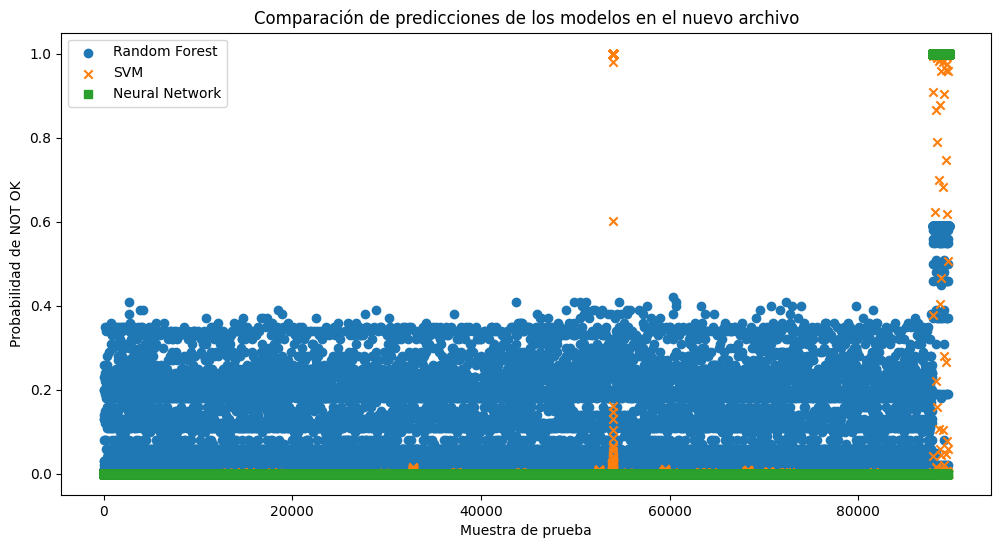

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset
import joblib
import matplotlib.pyplot as plt

# Cargar los modelos guardados
rf_model = joblib.load(r'C:\Users\luisg\OneDrive\Documentos\Proyecto_Fiverr\src\modelos\modelos\modelos\random_forest.pkl')
svm_model = joblib.load(r'C:\Users\luisg\OneDrive\Documentos\Proyecto_Fiverr\src\modelos\modelos\modelos\svm_model.pkl')

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(2, 64, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instanciar el modelo LSTM y cargar los pesos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
model.load_state_dict(torch.load(r'C:\Users\luisg\OneDrive\Documentos\Proyecto_Fiverr\src\modelos\modelos\modelos\lstm_model.pth'))

# Función para procesar los datos
def process_data(file_path):
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    df = df.dropna(axis=1, how='all').dropna(how='all')
    df_transposed = df.transpose().reset_index(drop=True)
    df_transposed.columns = [f'Col_{i}' for i in range(len(df_transposed.columns))]
    
    for col in df_transposed.columns:
        df_transposed[col] = pd.to_numeric(df_transposed[col], errors='coerce')
    df_transposed = df_transposed.dropna(how='all')
    df_transposed = df_transposed.iloc[:, :-3]

    ok_mask = df_transposed.iloc[0] == 0
    not_ok_mask = df_transposed.iloc[0] == 2

    df_ok = df_transposed.loc[:, ok_mask].reset_index(drop=True)
    df_not_ok = df_transposed.loc[:, not_ok_mask].reset_index(drop=True)

    def prepare_data(df, window_size=10):
        X = []
        y = []
        for i in range(1, df.shape[1], 2):
            if i + 1 >= df.shape[1]:
                break
            angulo = df.iloc[1:, i].dropna().values
            par = df.iloc[1:, i+1].dropna().values
            min_len = min(len(angulo), len(par))
            if min_len > window_size:
                for j in range(min_len - window_size):
                    X.append(np.column_stack((angulo[j:j+window_size], par[j:j+window_size])).flatten())
                    y.append(df.iloc[0, i])
        return np.array(X), np.array(y)

    X_ok, y_ok = prepare_data(df_ok)
    X_not_ok, y_not_ok = prepare_data(df_not_ok)

    y_ok = np.zeros_like(y_ok)
    y_not_ok = np.ones_like(y_not_ok)

    X = np.vstack((X_ok, X_not_ok))
    y = np.hstack((y_ok, y_not_ok))

    return X, y

# Procesar el nuevo archivo
file_path = r'C:\Users\luisg\OneDrive\Documentos\Proyecto_Fiverr\src\data\viejos\14_3.xlsx'
X, y = process_data(file_path)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Preparar los datos para PyTorch
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 10, 2))
dataset = TensorDataset(torch.tensor(X_reshaped, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Hacer predicciones con los modelos cargados
rf_predictions = rf_model.predict(X_scaled)
svm_predictions = svm_model.predict(X_scaled)

model.eval()
nn_predictions = []
with torch.no_grad():
    for X_batch, _ in loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()
        nn_predictions.extend(outputs.cpu().numpy())

nn_predictions = (np.array(nn_predictions) > 0.5).astype(int)

# Mostrar métricas de desempeño
print("Random Forest Performance:")
print(classification_report(y, rf_predictions))

print("\nSVM Performance:")
print(classification_report(y, svm_predictions))

print("\nNeural Network Performance:")
print(classification_report(y, nn_predictions))

# Visualización de las predicciones
plt.figure(figsize=(12, 6))
plt.scatter(range(len(X)), rf_model.predict_proba(X_scaled)[:, 1], label='Random Forest', marker='o')
plt.scatter(range(len(X)), svm_model.predict_proba(X_scaled)[:, 1], label='SVM', marker='x')
plt.scatter(range(len(X)), nn_predictions, label='Neural Network', marker='s')
plt.xlabel('Muestra de prueba')
plt.ylabel('Probabilidad de NOT OK')
plt.title('Comparación de predicciones de los modelos en el nuevo archivo')
plt.legend()
plt.savefig('comparacion_modelos_nuevo.png')
plt.show()


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import joblib
import matplotlib.pyplot as plt

# Cargar los modelos guardados
rf_model = joblib.load('/media/luis/86702BAA702B9FC3/Users/luisg/OneDrive/Documentos/Proyecto_Fiverr/src/modelos/modelos/random_forest.pkl')
svm_model = joblib.load('/media/luis/86702BAA702B9FC3/Users/luisg/OneDrive/Documentos/Proyecto_Fiverr/src/modelos/modelos/svm_model.pkl')

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(2, 128, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instanciar el modelo LSTM y cargar los pesos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
model.load_state_dict(torch.load('/media/luis/86702BAA702B9FC3/Users/luisg/OneDrive/Documentos/Proyecto_Fiverr/src/modelos/modelos/lstm_model.pth'))

# Función para procesar los datos
def process_data(file_path, window_size=100, step_size=50):
    df = pd.read_excel(file_path, sheet_name='Sheet1', header=None)
    df = df.drop(df.columns[[0, 2]], axis=1)  # Eliminar la primera y tercera columna
    estados = df.iloc[:, 0].values  # Guardar la primera columna (estados)
    df = df.apply(pd.to_numeric, errors='coerce')  # Convertir todo a numérico y manejar valores no numéricos
    df = df.dropna(how='all')  # Eliminar filas que son completamente NaN

    X, y = [], []  # Inicializar correctamente las listas vacías

    # Procesar cada par de filas (ángulo y par)
    for i in range(0, len(df), 2):
        if i + 1 < len(df):  # Asegurarse de que hay una fila par
            angulos = df.iloc[i].dropna().values
            pares = df.iloc[i + 1].dropna().values
            estado = estados[i]  # Obtener el estado de la primera fila del par

            # Asegurarse de que ambas filas tienen la misma longitud
            min_length = min(len(angulos), len(pares))
            angulos = angulos[:min_length]
            pares = pares[:min_length]

            # Generar ventanas
            for start in range(0, len(angulos) - window_size + 1, step_size):
                angulo_window = angulos[start:start + window_size]
                par_window = pares[start:start + window_size]

                if len(angulo_window) == window_size and len(par_window) == window_size:
                    X.append(np.column_stack((angulo_window, par_window)))
                    # Convertir el estado a binario (0 o 1)
                    y.append(1 if estado == 2 else 0)  # Convertir 2 a 1 para clasificación binaria

    X = np.array(X)
    y = np.array(y)

    return X, y

# Procesar el nuevo archivo
file_path = r'/media/luis/86702BAA702B9FC3/Users/luisg/OneDrive/Documentos/Proyecto_Fiverr/src/data/150_c.xlsx'
X, y = process_data(file_path)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Ajustar la forma de los datos para los modelos SVM y Random Forest
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], -1)

# Verificar si las características coinciden con las esperadas por el modelo SVM
print(f"Shape de los datos escalados: {X_scaled_reshaped.shape}")
print(f"Características esperadas por el SVM: {svm_model.n_features_in_}")

# Preparar los datos para PyTorch
test_dataset = TensorDataset(torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Hacer predicciones con los modelos cargados
rf_predictions = rf_model.predict(X_scaled_reshaped)
svm_predictions = svm_model.predict(X_scaled_reshaped)

model.eval()
nn_predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()
        nn_predictions.extend(outputs.cpu().numpy())

nn_predictions = (np.array(nn_predictions) > 0.5).astype(int)

# Mostrar métricas de desempeño
print("Random Forest Performance:")
print(classification_report(y, rf_predictions))

print("\nSVM Performance:")
print(classification_report(y, svm_predictions))

print("\nNeural Network Performance:")
print(classification_report(y, nn_predictions))

# Visualización de las predicciones
plt.figure(figsize=(12, 6))
plt.scatter(range(len(X)), rf_model.predict_proba(X_scaled_reshaped)[:, 1], label='Random Forest', marker='o')
plt.scatter(range(len(X)), svm_model.predict_proba(X_scaled_reshaped)[:, 1], label='SVM', marker='x')
plt.scatter(range(len(X)), nn_predictions, label='Neural Network', marker='s')
plt.xlabel('Muestra de prueba')
plt.ylabel('Probabilidad de NOT OK')
plt.title('Comparación de predicciones de los modelos en el nuevo archivo')
plt.legend()
plt.savefig('comparacion_modelos_nuevo.png')
plt.show()


/home/luis/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Shape de los datos PCA: (5338, 80)


ValueError: X has 80 features, but RandomForestClassifier is expecting 200 features as input.